In [1]:
import pandas as pd
import numpy as np
import json
import json
import umap as umap
import numpy as np
import json
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

/home/matt/miniforge3/envs/QSUR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_bgmms(dims, umap_folder, results_file):
    import json
    import pandas as pd
    from sklearn.mixture import BayesianGaussianMixture
    
    results = []
    for use in dims:
        data = pd.read_csv(f'{umap_folder}/umap_{use}.csv')
        
        # Use the correct number of components from dims.json
        bgmm = BayesianGaussianMixture(n_components=dims[use], random_state=42)
        bgmm.fit(data)
        
        # Calculate metrics
        loglik = bgmm.score(data) * len(data)
        n_parameters = (dims[use] * len(data.columns) * (len(data.columns) + 1) / 2) + (dims[use] * len(data.columns)) + (dims[use] - 1)
        aic = -2 * loglik + 2 * n_parameters
        bic = -2 * loglik + n_parameters * np.log(len(data))
        
        results.append({
            'use_case': use,
            'log_likelihood': loglik,
            'aic': aic,
            'bic': bic
        })
    
    pd.DataFrame(results).to_csv(results_file, index=False)

In [4]:
make_bgmms(50, '/home/matt/Proj/QSURv3/Data/ReducedForBGMM', 'bgmm_metrics50.csv')

TypeError: 'int' object is not iterable

In [6]:
import pickle
import numpy as np
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

In [5]:
def make_bgmms(dims, umap_folder, results_file):
    results = []
    
    for use, n_components in dims.items():
        try:
            data = pd.read_csv(f'{umap_folder}/umap_{use}.csv')
            
            # Early check for empty data
            if len(data) == 0:
                print(f"Skipping use {use}: empty dataset")
                continue
                
            bgmm = BayesianGaussianMixture(
                n_components=n_components,
                random_state=42,
                max_iter=1000,
                n_init=5
            )
            
            bgmm.fit(data)
            
            # Save the model
            with open(f'{umap_folder}/bgmm_{use}.pkl', 'wb') as f:
                pickle.dump(bgmm, f)
            
            # Calculate metrics
            n_samples = len(data)
            n_features = data.shape[1]
            loglik = bgmm.score(data) * n_samples
            n_parameters = (n_components * n_features * (n_features + 1) / 2) + \
                         (n_components * n_features) + (n_components - 1)
            
            results.append({
                'use_case': use,
                'n_components': n_components,
                'n_samples': n_samples,
                'log_likelihood': loglik,
                'aic': -2 * loglik + 2 * n_parameters,
                'bic': -2 * loglik + n_parameters * np.log(n_samples),
                'converged': bgmm.converged_
            })
            
        except Exception as e:
            print(f"Error processing use {use}: {str(e)}")
            
    pd.DataFrame(results).to_csv(results_file, index=False)

In [7]:
import pandas as pd
import numpy as np
import pickle
import glob
from sklearn.mixture import BayesianGaussianMixture

def make_bgmms(umap_folder, results_file, n_components=15):
   results = []
   umap_files = glob.glob(f'{umap_folder}/umap_*.csv')
   
   for file in umap_files:
       use = file.split('_')[-1].split('.')[0]  # Extract use number
       try:
           data = pd.read_csv(file)
           
           if len(data) == 0:
               print(f"Skipping use {use}: empty dataset")
               continue
               
           bgmm = BayesianGaussianMixture(
               n_components=n_components,
               random_state=42,
               max_iter=1000,
               n_init=5
           )
           
           bgmm.fit(data)
           
           with open(f'{umap_folder}/bgmm_{use}.pkl', 'wb') as f:
               pickle.dump(bgmm, f)
           
           n_samples = len(data)
           n_features = data.shape[1]
           loglik = bgmm.score(data) * n_samples
           n_parameters = (n_components * n_features * (n_features + 1) / 2) + \
                        (n_components * n_features) + (n_components - 1)
           
           results.append({
               'use_case': use,
               'n_samples': n_samples,
               'log_likelihood': loglik,
               'aic': -2 * loglik + 2 * n_parameters,
               'bic': -2 * loglik + n_parameters * np.log(n_samples),
               'converged': bgmm.converged_
           })
           
       except Exception as e:
           print(f"Error processing use {use}: {str(e)}")
           
   pd.DataFrame(results).to_csv(results_file, index=False)

In [8]:
make_bgmms('/home/matt/Proj/QSURv3/Data/ReducedForBGMM', 'bgmm_metrics.csv', n_components=15)

Error processing use 80: Found array with 1 sample(s) (shape=(1, 50)) while a minimum of 2 is required by BayesianGaussianMixture.
Error processing use 63: Found array with 1 sample(s) (shape=(1, 50)) while a minimum of 2 is required by BayesianGaussianMixture.
Error processing use 41: Found array with 1 sample(s) (shape=(1, 50)) while a minimum of 2 is required by BayesianGaussianMixture.


In [13]:
def plot_metrics(results_file, mapping):
   import pandas as pd
   import matplotlib.pyplot as plt
   
   # Load data and get only highest LL for each use case
   df = pd.read_csv(results_file)
   df = df.loc[df.groupby('use_case')['log_likelihood'].idxmax()]
   df['Category'] = df['use_case'].map(mapping)
   
   # Normalize each metric
   df_norm = df.copy()
   for col in ['aic', 'bic', 'log_likelihood']:
       df_norm[col] = df[col] / abs(df[col].sum())
   
   # Sort by the difference between log_likelihood and mean of AIC/BIC  
   df_norm['score'] = df_norm['log_likelihood'] - (df_norm['aic'] + df_norm['bic'])/2
   df_norm = df_norm.sort_values('score', ascending=True)
   
   # Plot
   my_range = range(1, len(df) + 1)
   plt.figure(figsize=(15,15))
   plt.rcParams.update({'font.size':15})
   
   plt.hlines(y=my_range, xmin=df_norm['log_likelihood'], xmax=df_norm['bic'], color='grey', alpha=0.4)
   plt.hlines(y=my_range, xmin=df_norm['log_likelihood'], xmax=df_norm['aic'], color='grey', alpha=0.4)
   plt.scatter(df_norm['log_likelihood'], my_range, color='blue', alpha=1, label='Log-Likelihood ')
   plt.scatter(df_norm['bic'], my_range, color='red', alpha=0.4, label='BIC')
   plt.scatter(df_norm['aic'], my_range, color='orange', alpha=0.4, label='AIC')
   
   plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.yticks(my_range, df_norm['Category'])
   plt.title("BGMM Model Quality by Category", loc='left')
   plt.xlabel('Normalized Metric Values')
   plt.ylabel('Category')
   
   plt.tight_layout()
   plt.show()

In [11]:
import json

with open('/home/matt/Proj/QSURv3/Curation/Wrangling/Harmonized Functional Use_mapping.json', 'r') as f:
   mapping = json.load(f)

In [15]:
mapping

{'Abrasive': 0,
 'Absorbent': 1,
 'Adhesion/cohesion promoter': 2,
 'Adsorbent': 3,
 'Alloying element': 4,
 'Anti-adhesive/cohesive': 5,
 'Anti-caking agent': 6,
 'Anti-dandruff (EPA)': 7,
 'Anti-freeze agent': 8,
 'Anti-redeposition agent': 9,
 'Anti-scaling agent': 10,
 'Anti-slip agent': 11,
 'Anti-stain agent': 12,
 'Anti-static agent': 13,
 'Anti-streaking agent': 14,
 'Antioxidant': 15,
 'Antiperspirant (EPA)': 16,
 'Astringent (EPA)': 17,
 'Binder': 18,
 'Biocide': 19,
 'Bleaching agent': 20,
 'Brightener': 21,
 'Chelating agent': 22,
 'Cleaning agent': 23,
 'Coalescing agent': 24,
 'Color scavenger (EPA)': 25,
 'Conductive agent': 26,
 'Corrosion inhibitor': 27,
 'Crystal growth modifiers (nucleating agents)': 28,
 'Deflocculant': 29,
 'Defoamer': 30,
 'Degradant/impurity (EPA)': 31,
 'Dehydrating agent (desiccant)': 32,
 'Demulsifier': 33,
 'Deodorizer': 34,
 'Depilatory (EPA)': 35,
 'Diluent': 36,
 'Dispersing agent': 37,
 'Drier': 38,
 'Dust suppressant': 39,
 'Dye': 40,
 '

In [19]:
import matplotlib.pyplot as plt

In [44]:
def plot_metrics(results_file, mapping):

    df = pd.read_csv(results_file)
    df = df.loc[df.groupby('use_case')['log_likelihood'].idxmax()]
    df['use_case'] = df['use_case'].astype(str)  # Convert to string to match mapping keys
    df['Category'] = df['use_case'].map(inv_map)


    # Rest of the code remains the same
    df_norm = df.copy()
    for col in ['aic', 'bic', 'log_likelihood']:
        df_norm[col] = df[col] / abs(df[col].sum())

    df_norm['score'] = df_norm['log_likelihood'] - (df_norm['aic'] + df_norm['bic'])/2
    df_norm = df_norm.sort_values('score', ascending=True)

    my_range = range(1, len(df) + 1)
    plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size':15})

    plt.hlines(y=my_range, xmin=df_norm['log_likelihood'], xmax=df_norm['bic'], color='grey', alpha=0.4)
    plt.hlines(y=my_range, xmin=df_norm['log_likelihood'], xmax=df_norm['aic'], color='grey', alpha=0.4)
    plt.scatter(df_norm['log_likelihood'], my_range, color='blue', alpha=1, label='Log-Likelihood ')
    plt.scatter(df_norm['bic'], my_range, color='red', alpha=0.4, label='BIC')
    plt.scatter(df_norm['aic'], my_range, color='orange', alpha=0.4, label='AIC')

    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.yticks(my_range, df_norm['Category'])
    plt.title("BGMM Model Quality by Category", loc='left')
    plt.xlabel('Normalized Metric Values')
    plt.ylabel('Category')

    plt.tight_layout()
    plt.show()

In [45]:
df = pd.read_csv('bgmm_metrics.csv')

In [37]:
df

,use_case,n_samples,log_likelihood,aic,bic,converged
0,81,6011,177673.960398,-315569.920795,-182286.842185,True
1,77,77,16075.821028,7626.357944,54242.303979,True
2,36,1691,263992.531278,-488207.062555,-380148.626941,True
3,31,1909,158434.323352,-277090.646704,-166620.481395,True
4,24,106,15762.731693,8252.536615,61225.676757,True
...,...,...,...,...,...,...
58,37,272,36684.701234,-33591.402469,38124.394828,True
59,38,77,13963.478320,11851.043359,58466.989394,True
60,13,709,87807.551755,-135837.103511,-45066.580944,True
61,17,105,16798.988322,6180.023356,58964.640760,True


In [38]:
inv_map = {str(v): k for k, v in mapping.items()}

In [39]:
df['Category'] = df['use_case'].map(inv_map)

In [40]:
inv_map

{'0': 'Abrasive',
 '1': 'Absorbent',
 '2': 'Adhesion/cohesion promoter',
 '3': 'Adsorbent',
 '4': 'Alloying element',
 '5': 'Anti-adhesive/cohesive',
 '6': 'Anti-caking agent',
 '7': 'Anti-dandruff (EPA)',
 '8': 'Anti-freeze agent',
 '9': 'Anti-redeposition agent',
 '10': 'Anti-scaling agent',
 '11': 'Anti-slip agent',
 '12': 'Anti-stain agent',
 '13': 'Anti-static agent',
 '14': 'Anti-streaking agent',
 '15': 'Antioxidant',
 '16': 'Antiperspirant (EPA)',
 '17': 'Astringent (EPA)',
 '18': 'Binder',
 '19': 'Biocide',
 '20': 'Bleaching agent',
 '21': 'Brightener',
 '22': 'Chelating agent',
 '23': 'Cleaning agent',
 '24': 'Coalescing agent',
 '25': 'Color scavenger (EPA)',
 '26': 'Conductive agent',
 '27': 'Corrosion inhibitor',
 '28': 'Crystal growth modifiers (nucleating agents)',
 '29': 'Deflocculant',
 '30': 'Defoamer',
 '31': 'Degradant/impurity (EPA)',
 '32': 'Dehydrating agent (desiccant)',
 '33': 'Demulsifier',
 '34': 'Deodorizer',
 '35': 'Depilatory (EPA)',
 '36': 'Diluent',
 '37

In [41]:
print(df['use_case'].head())
print(df['use_case'].dtype)

0    81
1    77
2    36
3    31
4    24
Name: use_case, dtype: int64
int64


In [43]:
df

,use_case,n_samples,log_likelihood,aic,bic,converged,Category
0,81,6011,177673.960398,-315569.920795,-182286.842185,True,NaN
1,77,77,16075.821028,7626.357944,54242.303979,True,NaN
2,36,1691,263992.531278,-488207.062555,-380148.626941,True,NaN
3,31,1909,158434.323352,-277090.646704,-166620.481395,True,NaN
4,24,106,15762.731693,8252.536615,61225.676757,True,NaN
...,...,...,...,...,...,...,...
58,37,272,36684.701234,-33591.402469,38124.394828,True,NaN
59,38,77,13963.478320,11851.043359,58466.989394,True,NaN
60,13,709,87807.551755,-135837.103511,-45066.580944,True,NaN
61,17,105,16798.988322,6180.023356,58964.640760,True,NaN


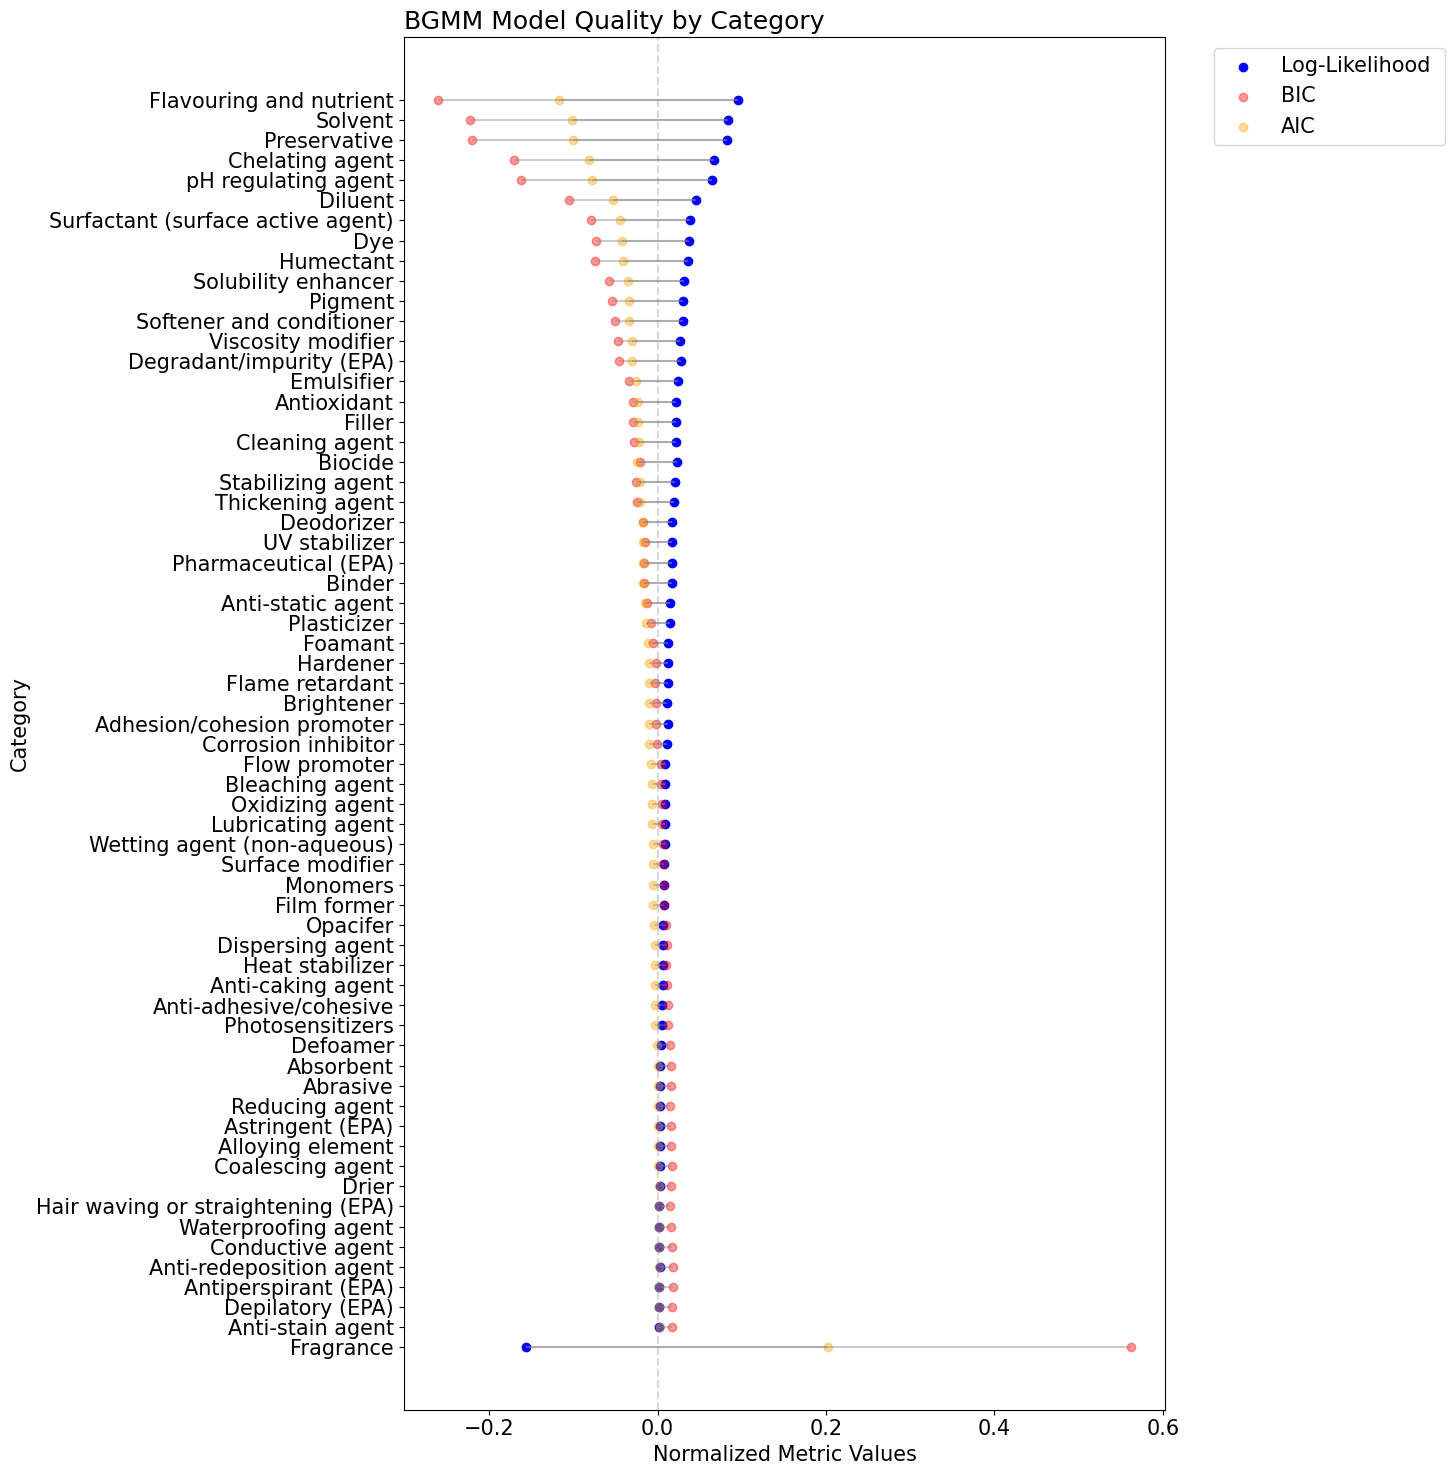

In [46]:
plot_metrics('bgmm_metrics.csv', mapping)

NameError: name 'df' is not defined